In [293]:
%matplotlib inline

import copy
import random

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import scipy as sp
import seaborn as sns

# Summary of Problem

In the real world, of course, there aren’t just 25 voters. Even if you can group neighborhoods together, the grid of voters in an entire state is going to be much larger, meaning that a computer program will probably be necessary to optimally gerrymander. Below is a rough approximation of Colorado’s voter preferences, based on county-level results from the 2012 presidential election, in a 14-by-10 grid. Colorado has seven districts, so each would have 20 voters in this model. What is the most districts that the Red Party could win if you get to draw the districts with the same rules as above? What about the Blue Party? (Assume ties within a district are considered wins for the party of your choice.)

http://i2.wp.com/espnfivethirtyeight.files.wordpress.com/2016/10/colorado.png?quality=90&strip=all&w=575&ssl=1

## plan of attack

simple monte carlo simulation. start with the base case of simplest possible division, update move is picking two districts at random and, if they share two border tracts, swap them.

## pseudocode approach

```python
m = DistrictMap()

while not m.done:
    m.update
```

In [349]:
D, R = 0, 1
coloradoArray = sp.array([
    [R, R, R, R, D, R, D, D, R, R, R, R, R, R],
    [R, R, R, D, D, R, D, D, R, R, R, R, R, R],
    [R, R, R, R, D, R, R, D, D, D, R, R, R, R],
    [R, R, R, R, D, D, D, D, D, D, R, R, R, R],
    [R, R, R, D, D, D, R, R, R, R, R, R, R, R],
    [R, R, R, D, D, R, R, R, R, R, R, R, R, R],
    [R, R, R, D, D, D, R, R, D, D, R, R, R, R],
    [D, D, D, R, D, D, D, R, D, D, R, R, R, R],
    [R, R, D, R, R, R, D, D, D, D, D, D, R, R],
    [R, D, D, R, R, D, D, D, D, D, D, D, R, R],
])        

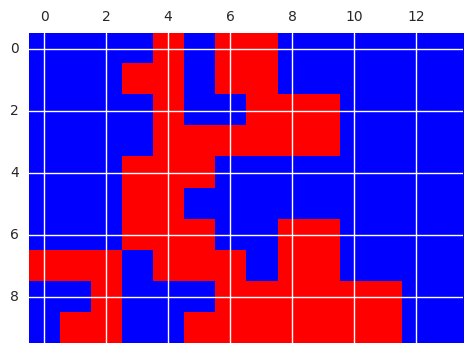

In [350]:
plt.matshow(coloradoArray, cmap=plt.cm.bwr_r);

In [351]:
I, J = coloradoArray.shape

def nodelabel(i, j):
    return i * J + j

cG = nx.Graph()

for i in range(I):
    for j in range(J):
        nodeLab = nodelabel(i, j)
        d, m = divmod(nodeLab, 20)
        cG.add_node(nodeLab, party=coloradoArray[i, j], district=d)
        
        # N
        if i != 0:
            cG.add_edge(nodeLab, nodelabel(i - 1, j))
            
        # S
        if i != I - 1:
            cG.add_edge(nodeLab, nodelabel(i + 1, j))
            
        # W
        if j != 0:
            cG.add_edge(nodeLab, nodelabel(i, j - 1))
            
        # E
        if j != J - 1:
            cG.add_edge(nodeLab, nodelabel(i, j + 1))

In [352]:
cG.nodes(data=True)

[(0, {'district': 0, 'party': 1}),
 (1, {'district': 0, 'party': 1}),
 (2, {'district': 0, 'party': 1}),
 (3, {'district': 0, 'party': 1}),
 (4, {'district': 0, 'party': 0}),
 (5, {'district': 0, 'party': 1}),
 (6, {'district': 0, 'party': 0}),
 (7, {'district': 0, 'party': 0}),
 (8, {'district': 0, 'party': 1}),
 (9, {'district': 0, 'party': 1}),
 (10, {'district': 0, 'party': 1}),
 (11, {'district': 0, 'party': 1}),
 (12, {'district': 0, 'party': 1}),
 (13, {'district': 0, 'party': 1}),
 (14, {'district': 0, 'party': 1}),
 (15, {'district': 0, 'party': 1}),
 (16, {'district': 0, 'party': 1}),
 (17, {'district': 0, 'party': 0}),
 (18, {'district': 0, 'party': 0}),
 (19, {'district': 0, 'party': 1}),
 (20, {'district': 1, 'party': 0}),
 (21, {'district': 1, 'party': 0}),
 (22, {'district': 1, 'party': 1}),
 (23, {'district': 1, 'party': 1}),
 (24, {'district': 1, 'party': 1}),
 (25, {'district': 1, 'party': 1}),
 (26, {'district': 1, 'party': 1}),
 (27, {'district': 1, 'party': 1}),
 (

In [356]:
class Districts(object):
    def __init__(self, stategraph, winthresh=10):
        self.stategraph = stategraph
        self.numtracts = self.stategraph.number_of_nodes()
        self.districtlabels = set(
            nx.get_node_attributes(self.stategraph, 'district').values()
        )
        self.winthresh = winthresh
        self._iters = 0
        self.most_wins = 0
        self.best_map = None
        
    def __getitem__(self, i):
        return self.stategraph.subgraph([
            n for (n, d) in self.stategraph.nodes_iter(data=True) 
            if d['district'] == i
        ])
        
    @property
    def done(self):
        self._iters += 1
        return self._iters == 100
        
    @property
    def districts(self):
        return {self.__getitem__(i) for i in self.districtlabels}
    
    def boundaries(self, d0, d1):
        return [
            edge for edge in self.stategraph.edges_iter()
            if set(self.stategraph.node[n]['district'] for n in edge) == set([d0, d1])
        ]
    
    def make_swap(self, swapnodes):
        n0, n1 = swapnodes
        newd1 = self.stategraph.node[n0]['district']
        newd0 = self.stategraph.node[n1]['district']
        self.stategraph.node[n0]['district'] = newd0
        self.stategraph.node[n1]['district'] = newd1
    
    def update(self):
        """for i = 2 or 3, pick i districts"""
        # doubles
        d0, d1 = random.sample(self.districtlabels, 2)
        bndry = self.boundaries(d0, d1)
        if len(bndry) >= 2:    
            for swapnodes in random.sample(bndry, 2):
                self.make_swap(swapnodes)
                
        # triples
        d0, d1, d2 = random.sample(self.districtlabels, 3)
        bndry01 = self.boundaries(d0, d1)
        bndry12 = self.boundaries(d1, d2)
        bndry20 = self.boundaries(d2, d0)
        if all([bndry01, bndry12, bndry20]):
            self.make_swap(random.choice(bndry01))
            self.make_swap(random.choice(bndry12))
            self.make_swap(random.choice(bndry20))
        
        self.status_report()
    
    @property
    def red_votes(self):
        return [
            sum(nx.get_node_attributes(district, 'party').values()) 
            for district in self.districts
        ]
    
    @property
    def red_wins(self):
        return [votes >= self.winthresh for votes in self.red_votes]
        
    def status_report(self):
        """print to screen the district totals and record best ever"""
        print(self.red_votes)
        wins = self.red_wins
        print(wins)
        numwins = sum(wins)
        if numwins > self.most_wins:
            self.most_wins = numwins
            self.best_map = copy.deepcopy(
                nx.get_node_attributes(self.stategraph, 'district')
            )
        self.show_map()
            
    def show_map(self):
        z = sp.zeros([10, 14])

        for n in range(140):
            z[divmod(n, 14)] = d.best_map[n]
            
        plt.matshow(z)
    
    def report_results(self):
        raise NotImplementedError()


In [357]:
d = Districts(cG)

[14, 9, 14, 13, 13, 12, 14]
[True, True, True, True, False, True, True]


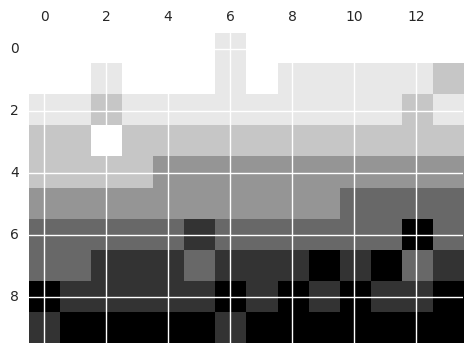

In [389]:
d.update()

[14, 15, 13, 10, 16, 13, 8]
[True, True, False, True, True, True, True]

[8, 15, 14, 13, 10, 16, 13]
[False, True, True, True, True, True, True]

[15, 10, 8, 13, 14, 16, 13]
[True, False, True, True, True, True, True]

[13, 13, 14, 16, 10, 8, 15]
[False, True, True, True, True, True, True]

[15, 13, 9, 9, 13, 14, 16]
[False, False, True, True, True, True, True]

[16, 9, 9, 13, 15, 13, 14]
[False, False, True, True, True, True, True]

[16, 13, 15, 9, 14, 9, 13]
[False, False, True, True, True, True, True]

[13, 14, 13, 16, 9, 9, 15]
[False, False, True, True, True, True, True]

[16, 13, 9, 14, 13, 15, 9]
[False, False, True, True, True, True, True]

[13, 15, 9, 9, 16, 13, 14]
[False, True, False, True, True, True, True]

[14, 9, 13, 9, 13, 15, 16]
[True, False, True, False, True, True, True]

[13, 9, 9, 13, 14, 15, 16]
[False, False, True, True, True, True, True]

[13, 15, 14, 16, 13, 9, 9]
[False, True, False, True, True, True, True]

[16, 9, 13, 14, 13, 9, 15]
[False, False, True, Tru

/Users/zach.lamberty/anaconda2/envs/bullshit3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[13, 9, 9, 15, 14, 13, 16]
[False, False, True, True, True, True, True]

[14, 13, 9, 9, 15, 13, 16]
[True, False, False, True, True, True, True]

[16, 14, 13, 9, 9, 15, 13]
[False, True, False, True, True, True, True]

[13, 16, 13, 14, 9, 9, 15]
[True, False, False, True, True, True, True]

[9, 14, 13, 15, 16, 13, 9]
[False, True, True, False, True, True, True]

[9, 13, 15, 16, 14, 13, 9]
[False, False, True, True, True, True, True]

[13, 9, 9, 13, 15, 16, 14]
[False, False, True, True, True, True, True]

[13, 9, 9, 14, 13, 15, 16]
[False, False, True, True, True, True, True]

[16, 14, 13, 9, 9, 13, 15]
[False, True, False, True, True, True, True]

[9, 15, 14, 13, 16, 13, 9]
[False, False, True, True, True, True, True]

[9, 15, 14, 13, 16, 13, 9]
[False, False, True, True, True, True, True]

[16, 13, 9, 15, 14, 9, 13]
[False, False, True, True, True, True, True]

[9, 14, 13, 15, 16, 13, 9]
[False, True, False, True, True, True, True]

[15, 14, 13, 16, 13, 9, 9]
[False, True, False, Tru

KeyboardInterrupt: 

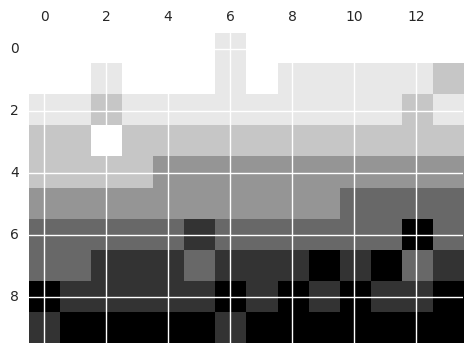

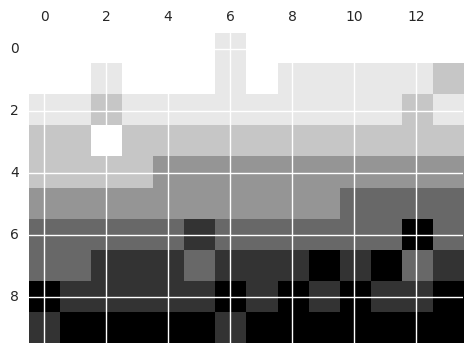

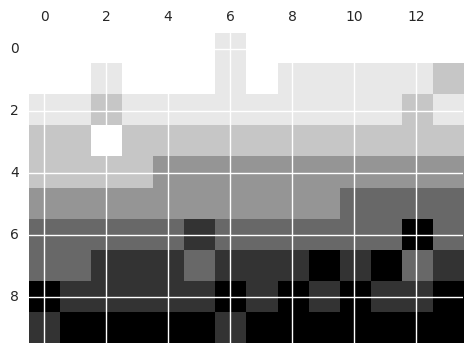

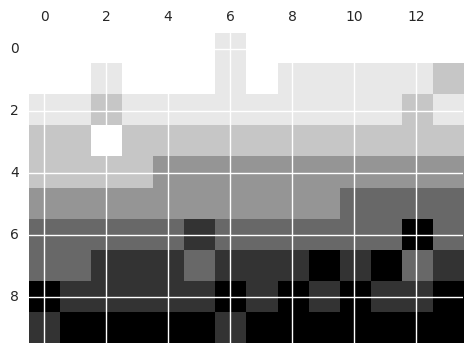

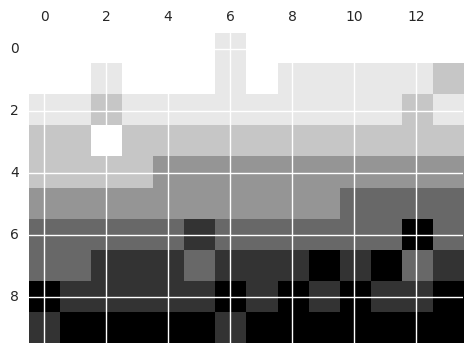

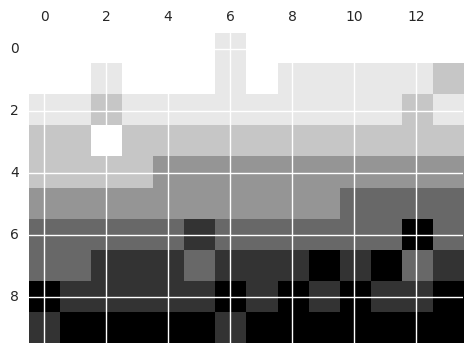

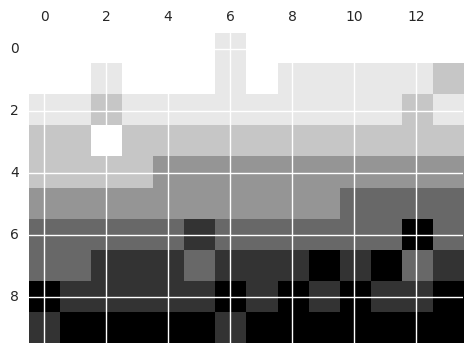

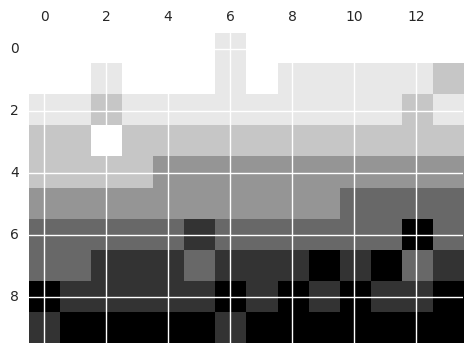

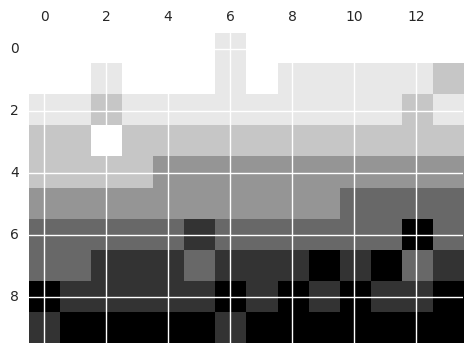

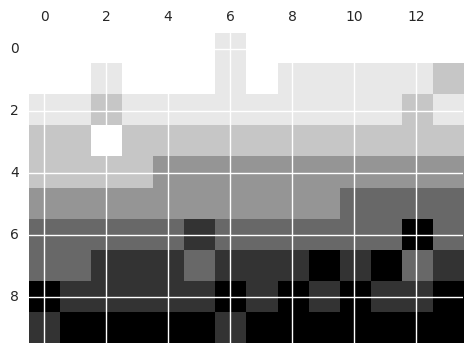

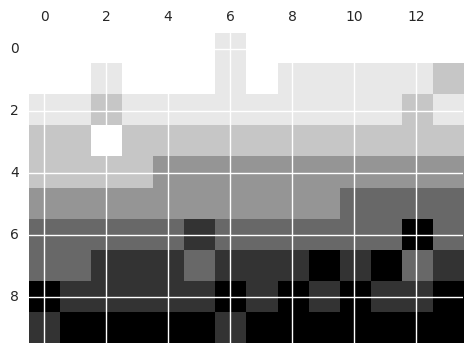

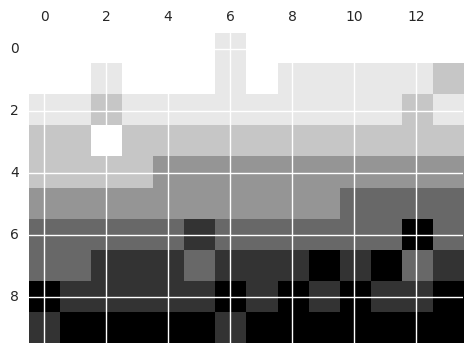

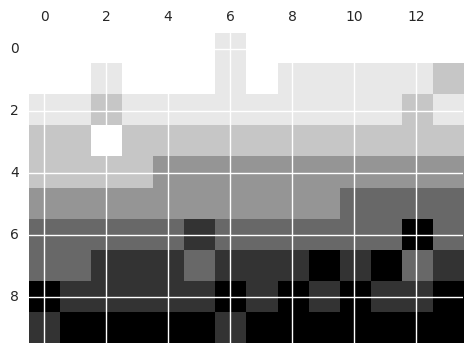

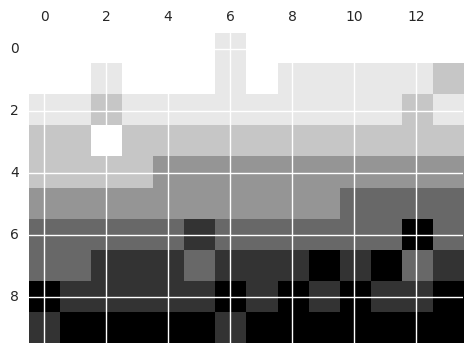

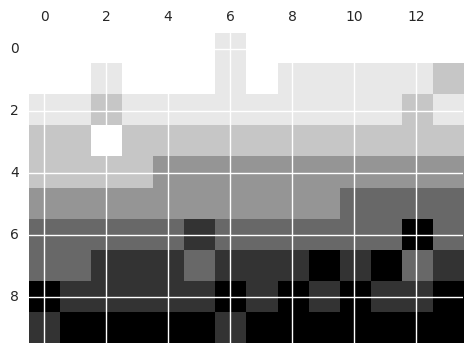

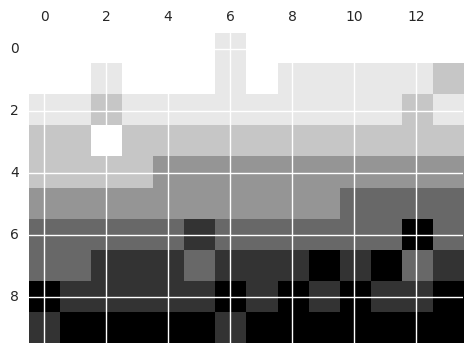

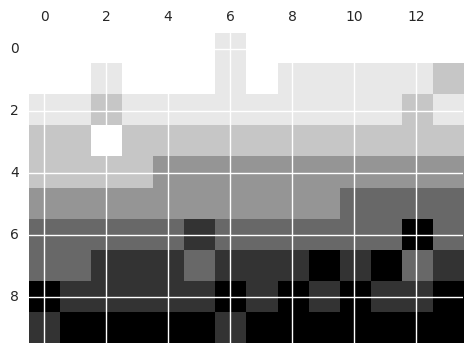

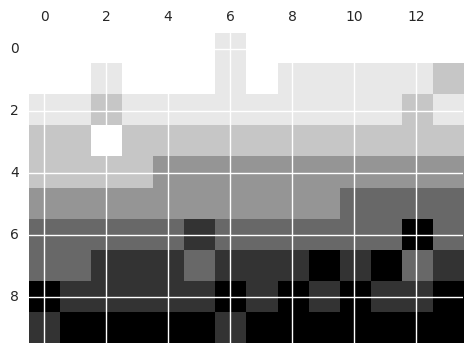

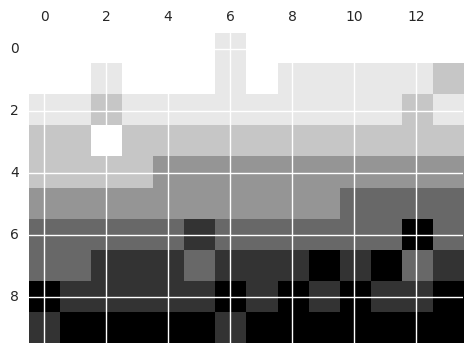

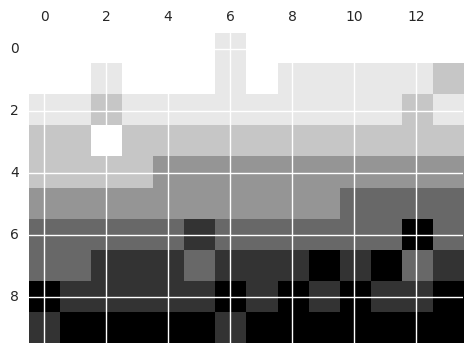

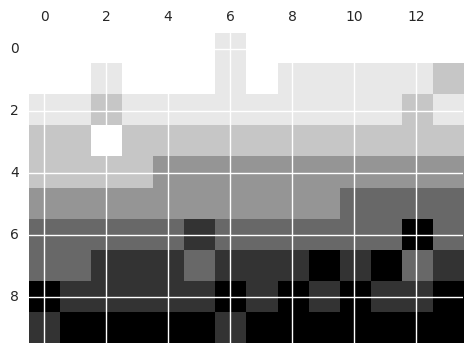

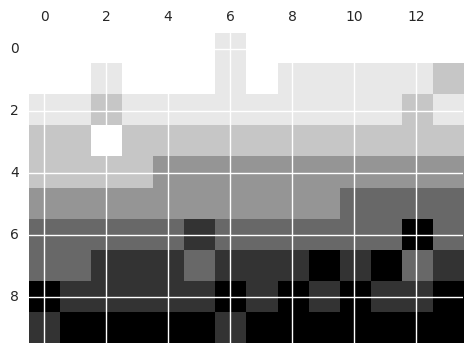

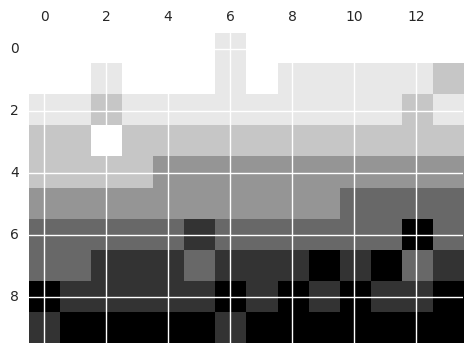

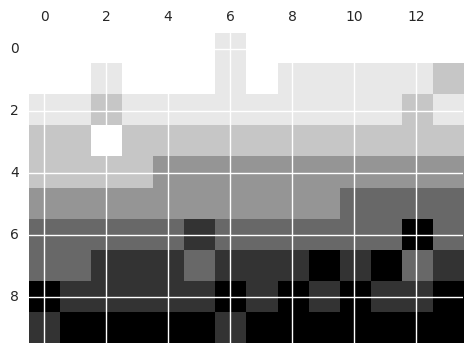

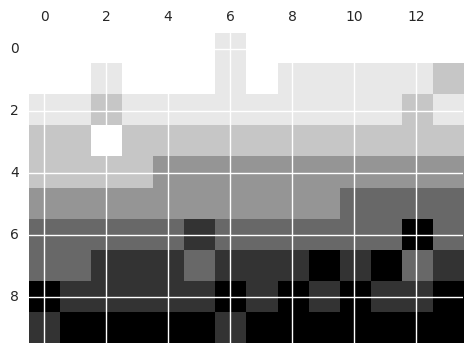

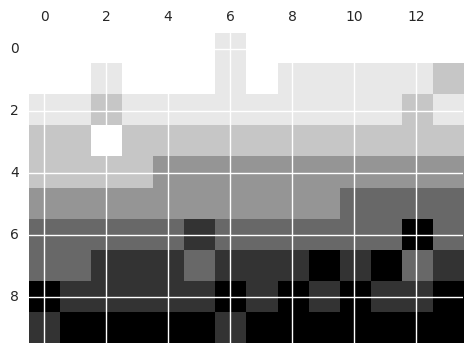

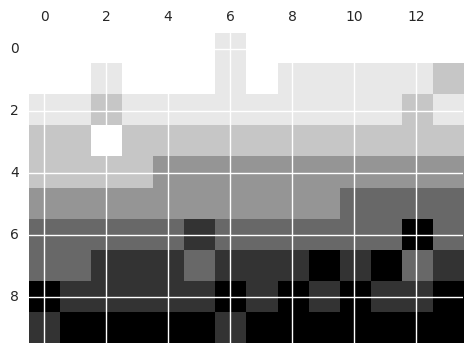

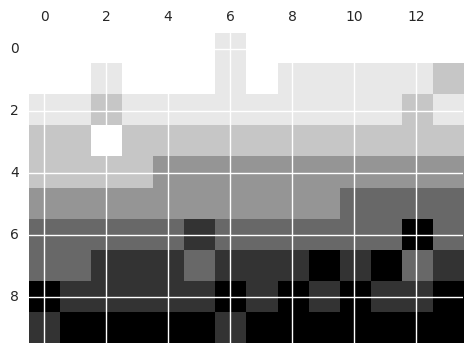

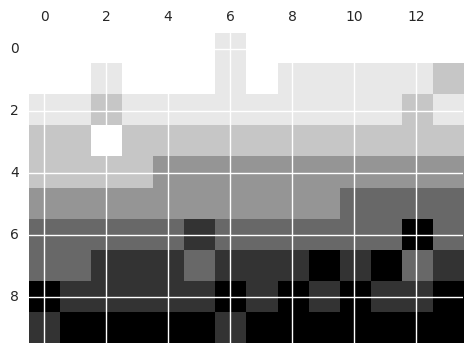

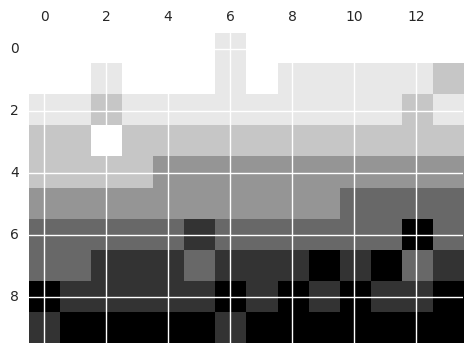

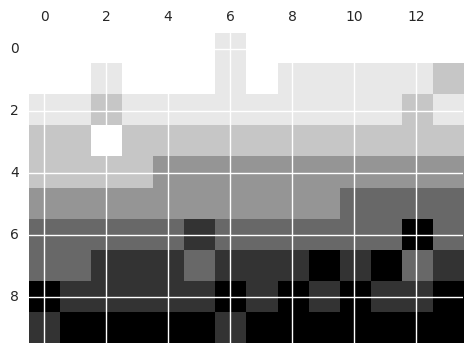

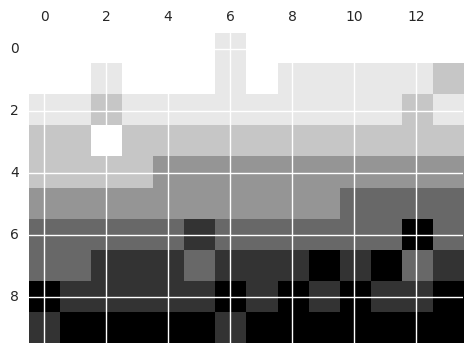

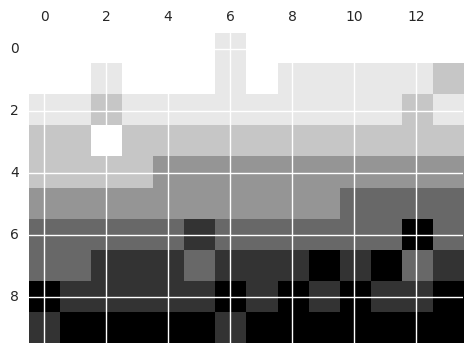

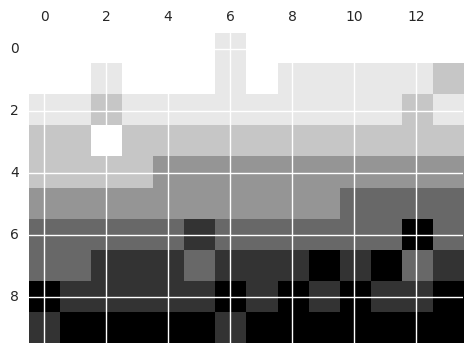

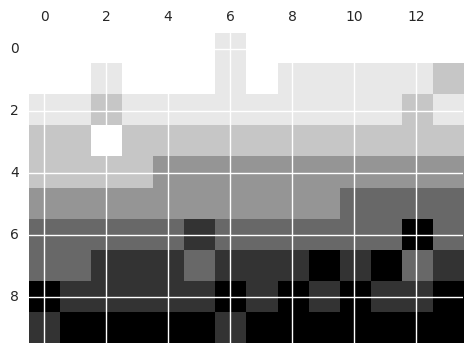

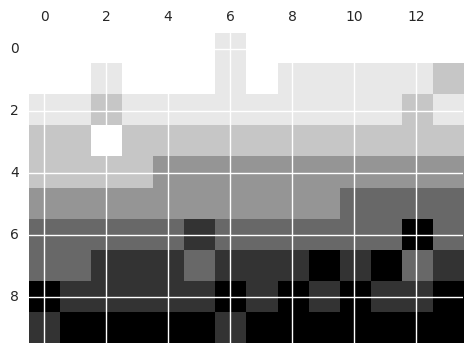

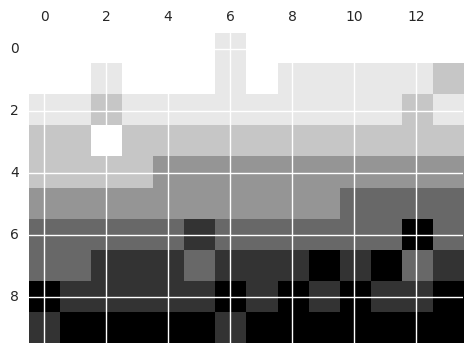

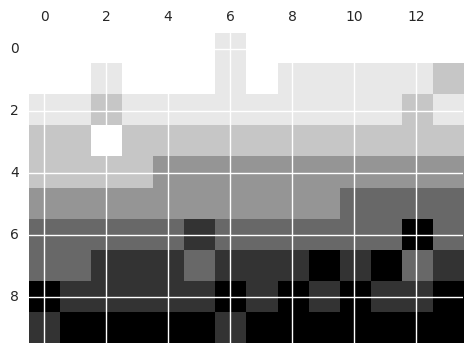

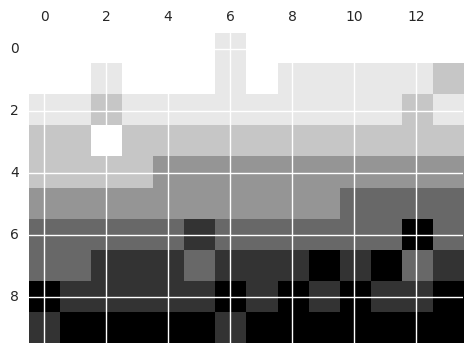

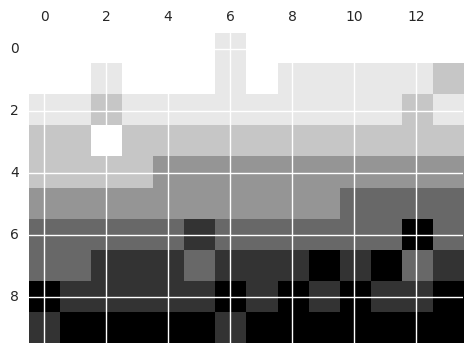

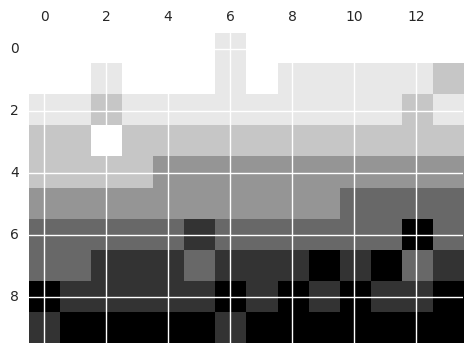

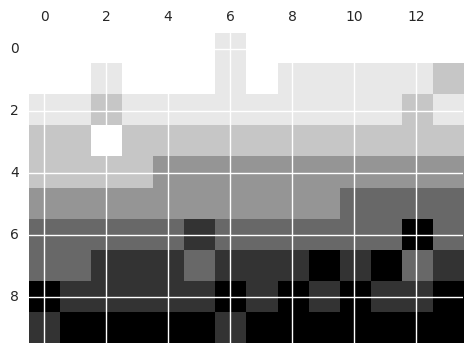

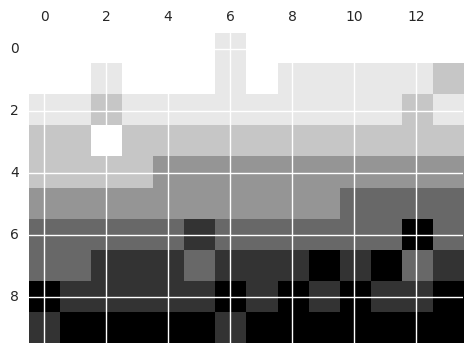

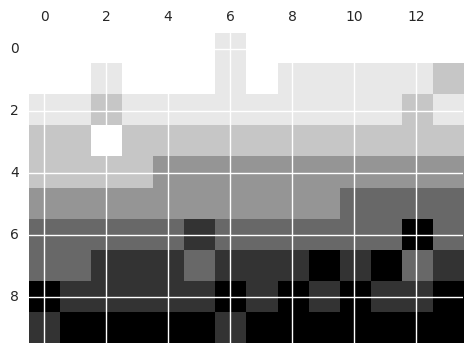

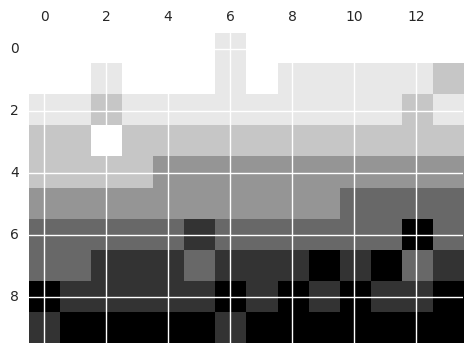

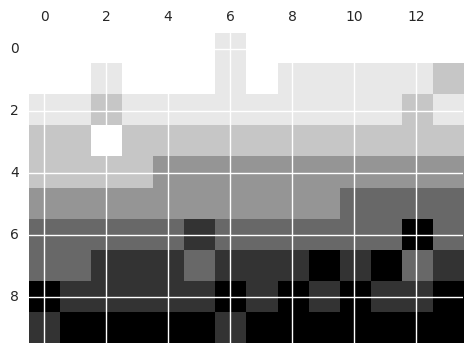

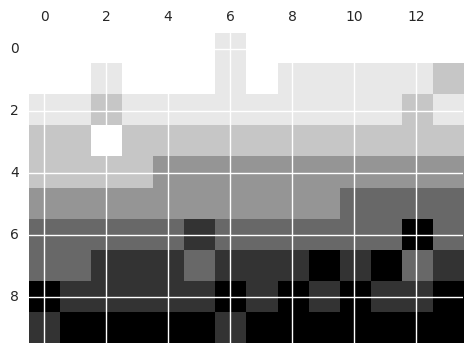

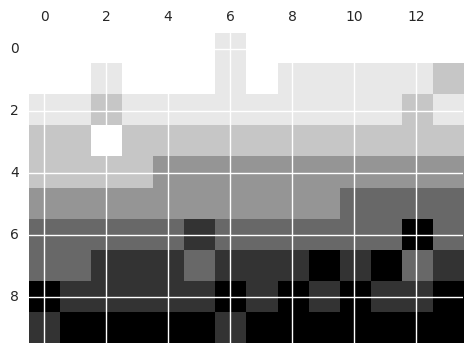

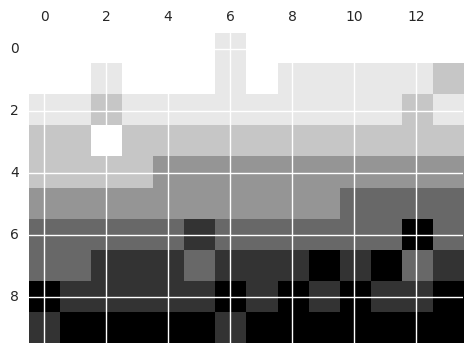

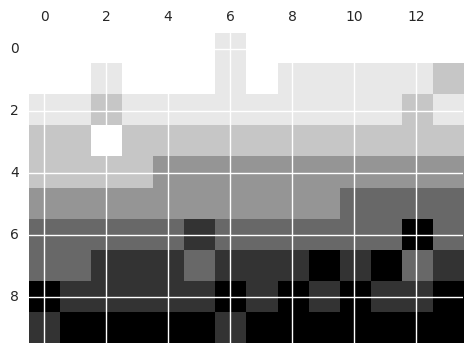

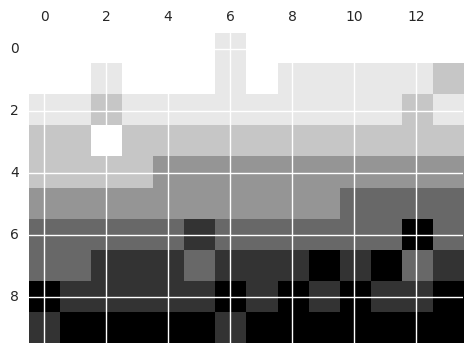

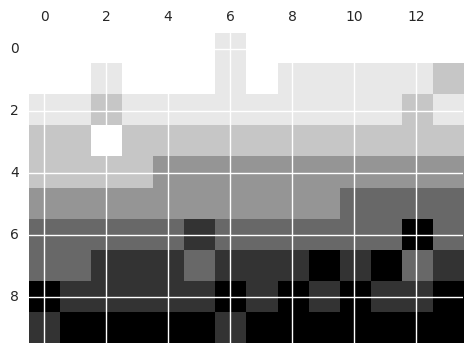

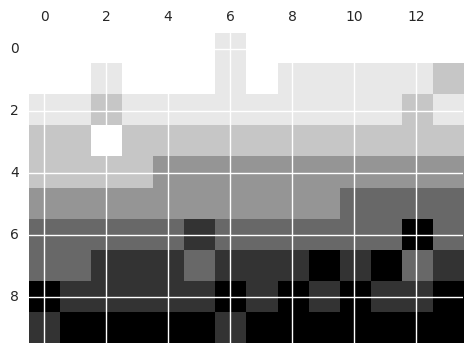

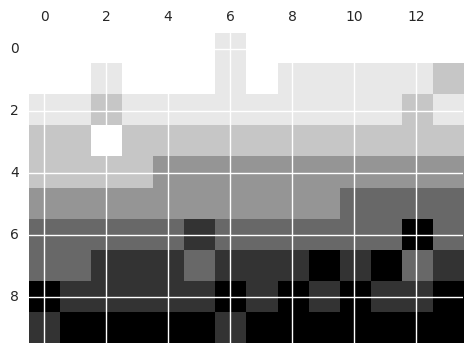

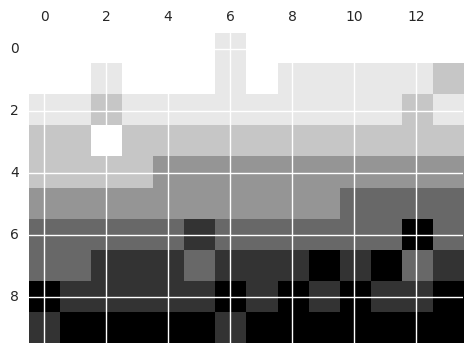

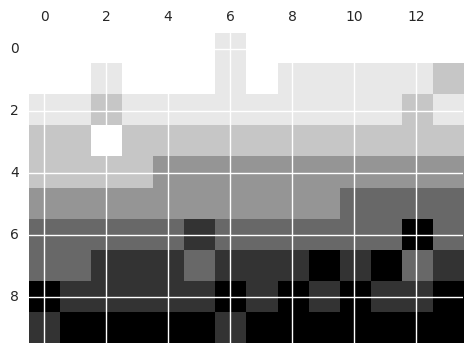

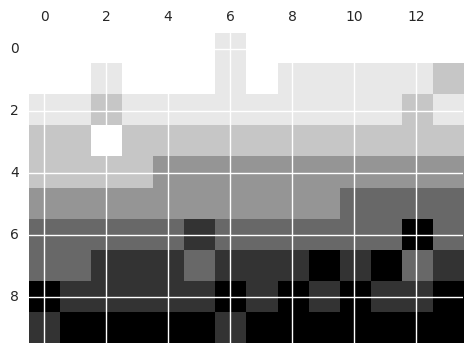

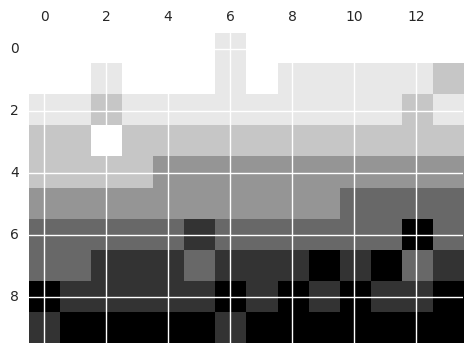

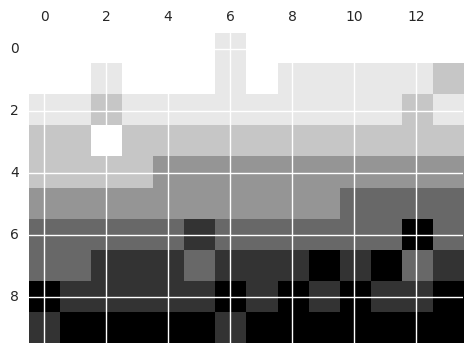

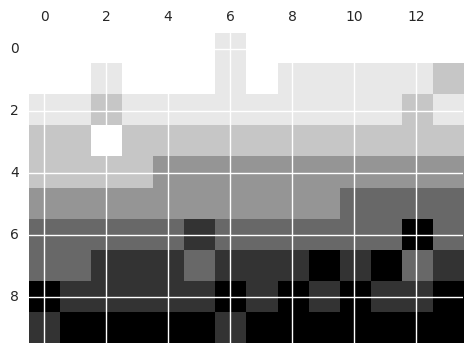

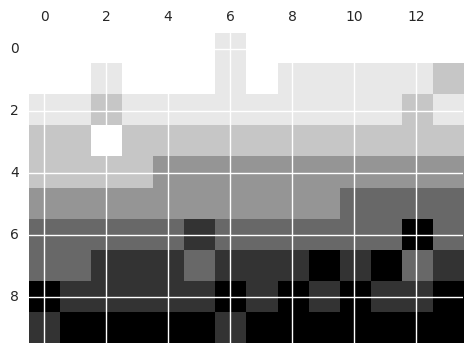

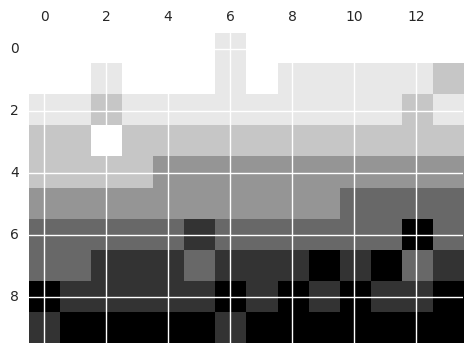

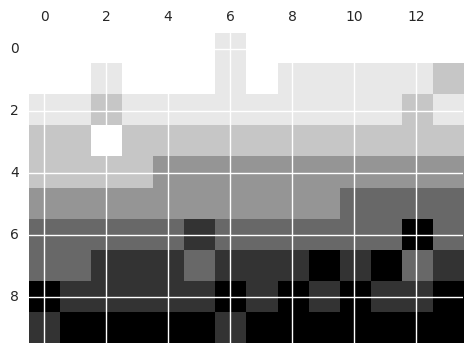

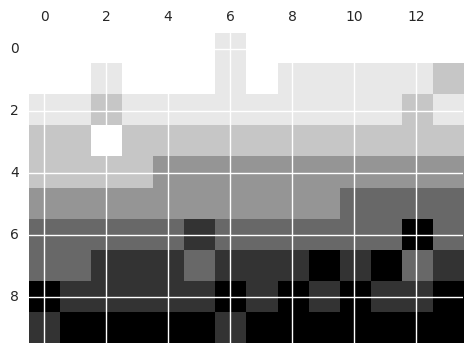

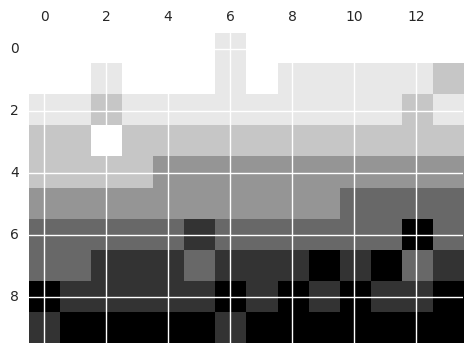

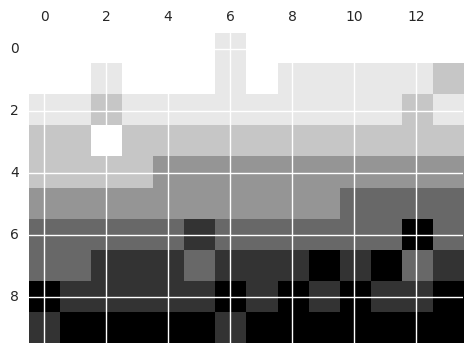

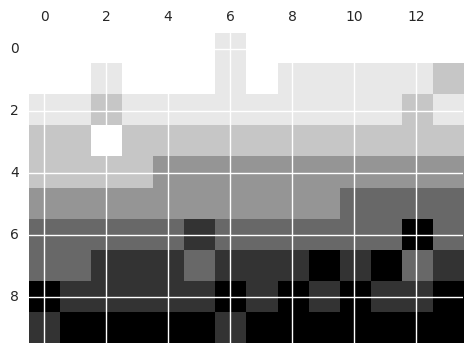

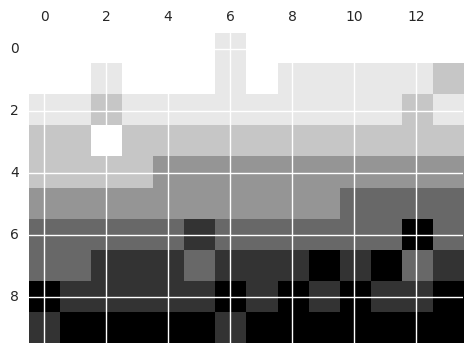

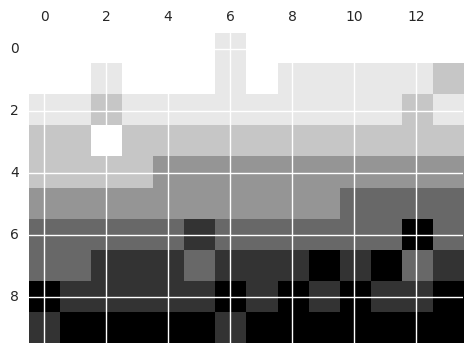

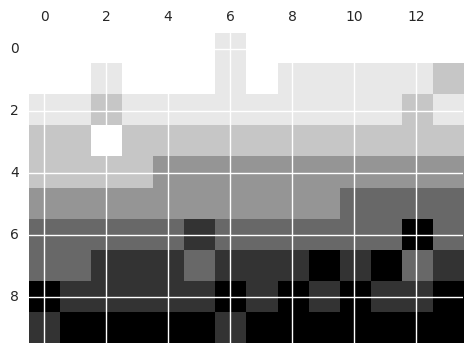

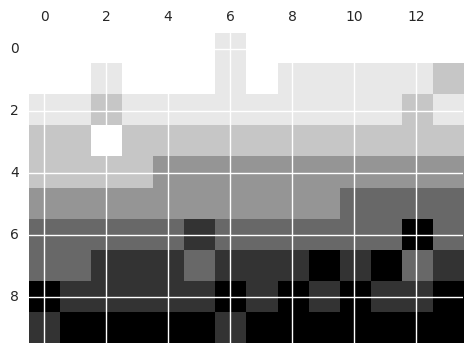

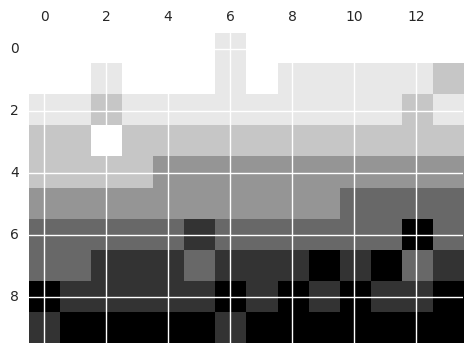

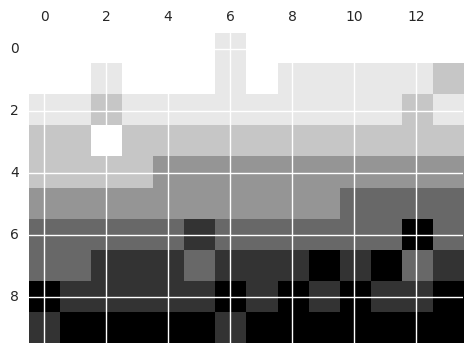

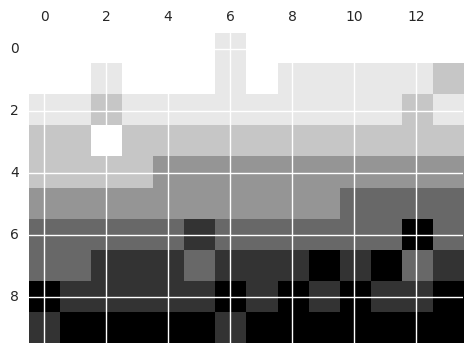

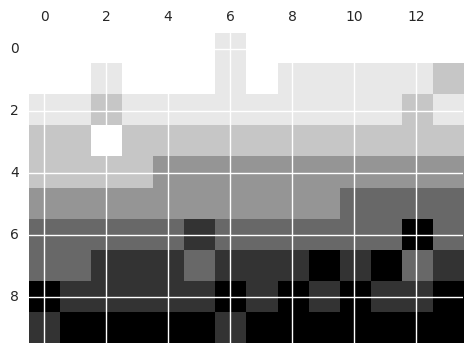

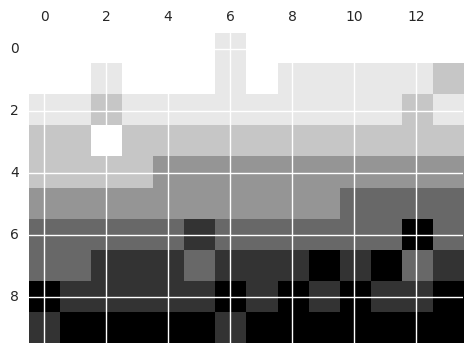

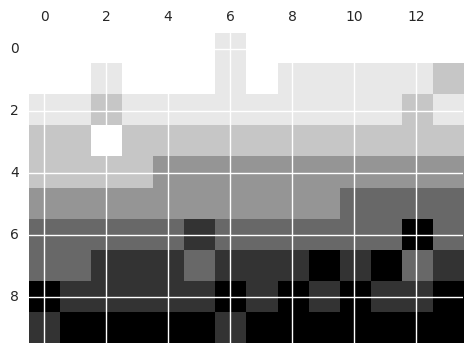

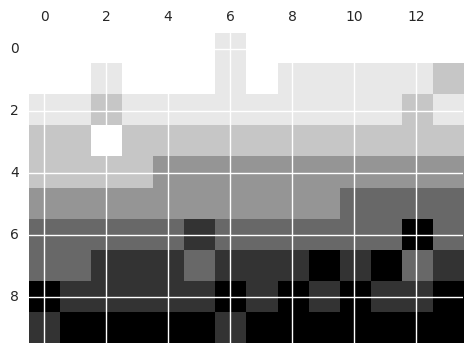

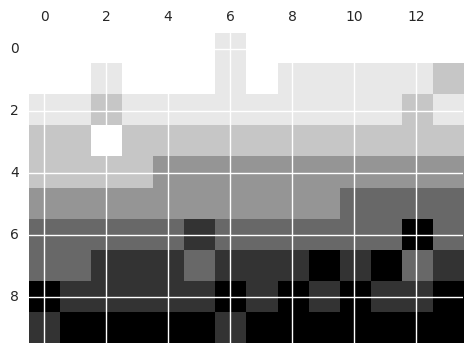

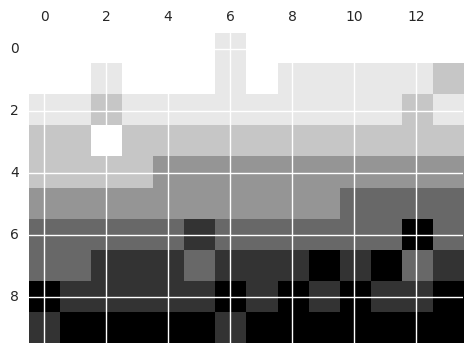

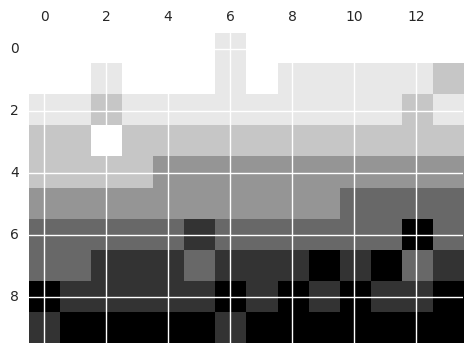

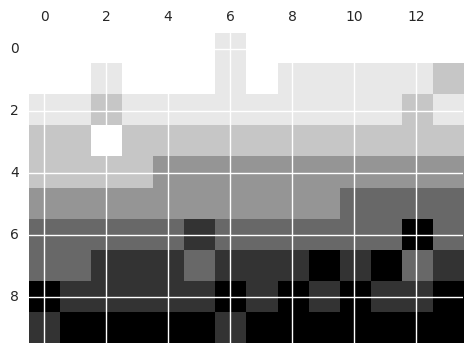

In [388]:
d = Districts(cG)

while not d.done:
    d.update()
    input()
    
d.report_results()

In [ ]:
d.most_wins



In [335]:
d.best_map

{0: 2,
 1: 0,
 2: 2,
 3: 2,
 4: 0,
 5: 2,
 6: 6,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 4,
 13: 6,
 14: 2,
 15: 0,
 16: 0,
 17: 1,
 18: 0,
 19: 1,
 20: 4,
 21: 2,
 22: 1,
 23: 3,
 24: 3,
 25: 0,
 26: 5,
 27: 0,
 28: 4,
 29: 3,
 30: 3,
 31: 4,
 32: 5,
 33: 2,
 34: 0,
 35: 1,
 36: 1,
 37: 3,
 38: 4,
 39: 3,
 40: 0,
 41: 2,
 42: 2,
 43: 4,
 44: 1,
 45: 2,
 46: 4,
 47: 3,
 48: 1,
 49: 2,
 50: 3,
 51: 1,
 52: 6,
 53: 0,
 54: 0,
 55: 1,
 56: 2,
 57: 1,
 58: 3,
 59: 4,
 60: 0,
 61: 4,
 62: 6,
 63: 5,
 64: 5,
 65: 0,
 66: 2,
 67: 3,
 68: 0,
 69: 1,
 70: 5,
 71: 2,
 72: 1,
 73: 6,
 74: 0,
 75: 5,
 76: 6,
 77: 5,
 78: 5,
 79: 6,
 80: 2,
 81: 0,
 82: 4,
 83: 1,
 84: 4,
 85: 6,
 86: 4,
 87: 3,
 88: 2,
 89: 4,
 90: 3,
 91: 4,
 92: 6,
 93: 6,
 94: 5,
 95: 3,
 96: 3,
 97: 6,
 98: 5,
 99: 5,
 100: 6,
 101: 0,
 102: 6,
 103: 0,
 104: 5,
 105: 4,
 106: 4,
 107: 3,
 108: 2,
 109: 6,
 110: 6,
 111: 3,
 112: 3,
 113: 6,
 114: 6,
 115: 5,
 116: 4,
 117: 5,
 118: 5,
 119: 1,
 120: 5,
 121: 5,
 122: 1,
 12

In [338]:
z = sp.zeros([I, J])

for n in range(140):
    z[divmod(n, 14)] = d.best_map[n]
    
z
    

array([[ 2.,  0.,  2.,  2.,  0.,  2.,  6.,  1.,  1.,  1.,  1.,  1.,  4.,
         6.],
       [ 2.,  0.,  0.,  1.,  0.,  1.,  4.,  2.,  1.,  3.,  3.,  0.,  5.,
         0.],
       [ 4.,  3.,  3.,  4.,  5.,  2.,  0.,  1.,  1.,  3.,  4.,  3.,  0.,
         2.],
       [ 2.,  4.,  1.,  2.,  4.,  3.,  1.,  2.,  3.,  1.,  6.,  0.,  0.,
         1.],
       [ 2.,  1.,  3.,  4.,  0.,  4.,  6.,  5.,  5.,  0.,  2.,  3.,  0.,
         1.],
       [ 5.,  2.,  1.,  6.,  0.,  5.,  6.,  5.,  5.,  6.,  2.,  0.,  4.,
         1.],
       [ 4.,  6.,  4.,  3.,  2.,  4.,  3.,  4.,  6.,  6.,  5.,  3.,  3.,
         6.],
       [ 5.,  5.,  6.,  0.,  6.,  0.,  5.,  4.,  4.,  3.,  2.,  6.,  6.,
         3.],
       [ 3.,  6.,  6.,  5.,  4.,  5.,  5.,  1.,  5.,  5.,  1.,  2.,  6.,
         6.],
       [ 4.,  0.,  6.,  2.,  3.,  0.,  5.,  5.,  3.,  5.,  3.,  4.,  2.,
         4.]])

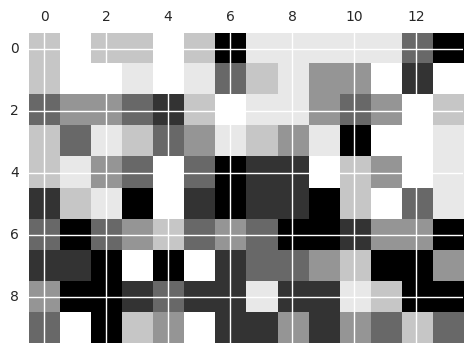

In [339]:
plt.matshow(z)